# Demo of a simple futures trend following strategy

Load modules. The heavy-lifting is done by `futures.py`

In [1]:
import datetime, os, sys, itertools, re, math

import numpy as np
import pandas as pd
pd.options.display.max_rows = 500
import matplotlib.pyplot as plt

import importlib
import futures

meta = futures.meta

In [12]:
risk_factor = 0.002
equity = 1000000

data_start = 2003
data_end = 2016
day_first_position = "2004-01-01"
symbols = list(futures.ready_meta(data_start)['Quandl Symbol'])

df = futures.load_continuous_future(symbols, start_year=data_start, end_year=data_end, method="backward")
df.columns = pd.MultiIndex.from_tuples( list(itertools.product(symbols, ['price'])) )

# if any one of the symbol misses a day, remove that day for all the symbols
df.dropna(how='any', inplace=True)

#### Currently we have the following symbols on the metadata database:

In [13]:
symbols

['CME/AD',
 'CME/BP',
 'CME/CD',
 'CME/EC',
 'CME/SF',
 'CME/JY',
 'CME/SP',
 'CME/US',
 'CME/TY',
 'CME/FV',
 'CME/TU',
 'CME/FF',
 'CME/SI',
 'CME/GC',
 'CME/CL',
 'CME/NG',
 'CME/HO',
 'CME/C',
 'CME/S',
 'CME/W',
 'CME/LC',
 'CME/LN',
 'CME/SM',
 'CME/BO',
 'ICE/CC',
 'ICE/KC',
 'ICE/SB',
 'ICE/CT',
 'CME/O',
 'CME/PA',
 'CME/PL',
 'CME/LB',
 'CME/RR',
 'CME/NE']

#### Here's what our main data structure looks after the contracts adjustments:

In [14]:
df.tail()

,CME/AD,CME/BP,CME/CD,CME/EC,CME/SF,CME/JY,CME/SP,CME/US,CME/TY,CME/FV,...,ICE/CC,ICE/KC,ICE/SB,ICE/CT,CME/O,CME/PA,CME/PL,CME/LB,CME/RR,CME/NE
,price,price,price,price,price,price,price,price,price,price,...,price,price,price,price,price,price,price,price,price,price
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-23,0.7156,1.2299,0.73940,1.04910,0.9786,8563.5,2260.0,149.12500,123.359375,117.078125,...,2264.0,136.15,18.15,69.87,218.50,654.85,895.0,318.6,9.460,0.6852
2016-12-27,0.7172,1.2300,0.73760,1.05015,0.9780,8546.5,2260.9,148.56250,123.203125,116.984375,...,2237.0,134.20,18.54,69.74,228.50,673.80,905.9,316.3,9.535,0.6873
2016-12-28,0.7171,1.2248,0.73845,1.04580,0.9774,8566.5,2245.3,149.71875,123.640625,117.257812,...,2205.0,133.50,18.99,69.75,227.75,666.85,902.2,322.5,9.505,0.6907
2016-12-29,0.7195,1.2274,0.74175,1.05210,0.9808,8600.5,2245.1,149.90625,123.937500,117.500000,...,2165.0,135.45,19.49,70.50,226.50,675.65,902.4,324.5,9.505,0.6939
2016-12-30,0.7202,1.2358,0.74415,1.05740,0.9866,8597.0,2236.2,150.65625,124.281250,117.664062,...,2126.0,137.05,19.51,70.65,228.50,683.25,905.7,329.4,9.610,0.6924


#### A strategy consists of a way to choose position directions and a way to choose position sizes:

In [15]:
for symbol in df.columns.get_level_values(0):
    point_value =  meta.set_index("Quandl Symbol").loc[symbol, "point_value"]

    df.loc[:,(symbol, "direction")] = futures.get_direction_ma(price=df.loc[:,(symbol,"price")],
                                                               day_first_position=day_first_position,
                                                               SMA=10,
                                                               LMA=100)

    df.loc[:,(symbol, "sizing")] = futures.get_sizing(price=df.loc[:,(symbol,"price")],
                                                      equity=equity,
                                                      risk_factor=risk_factor,
                                                      point_value=point_value)

    df.loc[:,(symbol, "pnlpercontract")] = futures.get_pnl_per_contract(price=df.loc[:,(symbol,"price")],
                                                                        direction=df.loc[:,(symbol,"direction")],
                                                                        point_value=point_value)

    df.loc[:,(symbol, "pnl")] = df.loc[:,(symbol,"pnlpercontract")] * df.loc[:, (symbol,"sizing")]


    
df = df[list(itertools.product(symbols,["price","direction","sizing","pnlpercontract","pnl"]))]

df['totalpnl'] = df[list(itertools.product(symbols,["pnl"]))].sum(axis=1)
df['totalrunningpnl'] = df['totalpnl'].cumsum()

#### Here's what our main data structure looks like after the strategy has been backtested:

In [16]:
df.tail()

CME/AD                                          CME/BP            \
             price direction sizing pnlpercontract     pnl   price direction   
Date                                                                           
2016-12-23  0.7156      -1.0    4.0          390.0  1560.0  1.2299      -1.0   
2016-12-27  0.7172      -1.0    4.0         -160.0  -640.0  1.2300      -1.0   
2016-12-28  0.7171      -1.0    4.0           10.0    40.0  1.2248      -1.0   
2016-12-29  0.7195      -1.0    4.0         -240.0  -960.0  1.2274      -1.0   
2016-12-30  0.7202      -1.0    4.0          -70.0  -280.0  1.2358      -1.0   

                                               ...       CME/RR  \
           sizing pnlpercontract     pnl       ...       sizing   
Date                                           ...                
2016-12-23    4.0          81.25   325.0       ...          5.0   
2016-12-27    4.0          -6.25   -25.0       ...          5.0   
2016-12-28    4.0         325.00  1300.0       ...          5.0   
2016-12-29    4.0        -162.50  -650.0       ...          5.0   
2016-12-30    4.0        -525.00 -2100.0       ...          6.0   

                                   CME/NE                                  \
           pnlpercontract     pnl   price direction sizing pnlpercontract   
Date                                                                        
2016-12-23          120.0   600.0  0.6852      -1.0    4.0          350.0   
2016-12-27         -150.0  -750.0  0.6873      -1.0    4.0         -210.0   
2016-12-28           60.0   300.0  0.6907      -1.0    4.0         -340.0   
2016-12-29           -0.0    -0.0  0.6939      -1.0    4.0         -320.0   
2016-12-30         -210.0 -1260.0  0.6924      -1.0    4.0          150.0   

                     totalpnl totalrunningpnl  
               pnl                             
Date                                           
2016-12-23  1400.0   1379.425    1.724404e+06  
2016-12-27  -840.0  16221.500    1.740625e+06  
2016-12-28 -1360.0  -7652.625    1.732973e+06  
2016-12-29 -1280.0 -25025.575    1.707947e+06  
2016-12-30   600.0 -17376.075    1.690571e+06  

[5 rows x 172 columns]

#### And here's the returns curve:

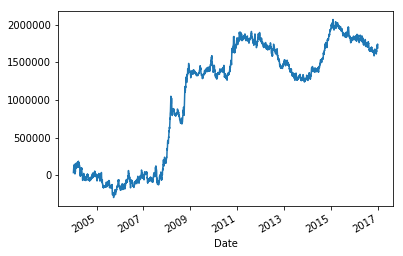

In [17]:
df['totalrunningpnl'].plot()
plt.show()